In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import requests, zipfile, StringIO
import urllib2
import urllib
import json
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import shapely
import fiona
import matplotlib.pylab as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
# fname = 'cb_2015_36_tract_500k.zip'
# zf = zipfile.ZipFile(fname)
# #dic[i] = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
# ct_shape = gp.GeoDataFrame.from_file(zf.open('cb_2015_36_tract_500k.shp'))

In [4]:
ct_shape = gp.GeoDataFrame.from_file('cb_2015_36_tract_500k\cb_2015_36_tract_500k.shp')

In [5]:
ct_shape.head()

,AFFGEOID,ALAND,AWATER,COUNTYFP,GEOID,LSAD,NAME,STATEFP,TRACTCE,geometry
0,1400000US36001000502,777446,0,001,36001000502,CT,5.02,36,000502,"POLYGON ((-73.79496 42.66871, -73.790798999999..."
1,1400000US36001013507,5575232,2491,001,36001013507,CT,135.07,36,013507,"POLYGON ((-73.802734 42.763943, -73.796492 42...."
2,1400000US36001014612,3072859,243,001,36001014612,CT,146.12,36,014612,"POLYGON ((-74.045469 42.711973, -74.0415709999..."
3,1400000US36001014803,149682672,1926625,001,36001014803,CT,148.03,36,014803,"POLYGON ((-74.11678499999999 42.551517, -74.09..."
4,1400000US36003940200,1528842,26577,003,36003940200,CT,9402,36,940200,"POLYGON ((-78.309316 42.231684, -78.309145 42...."


In [6]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 49105 (mi^2)


In [7]:
ct_shape_Zoom=(ct_shape[ct_shape.centroid.apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

__CUSP coordinates: {-73.986403, 40.693217}__ (_source_: maps.google.com)

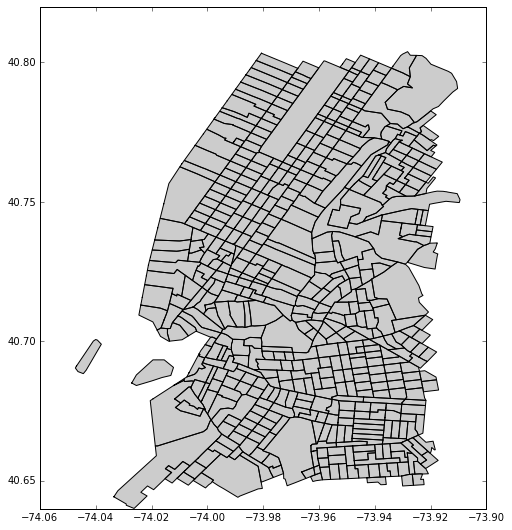

In [134]:
ct_shape_Zoom.plot(figsize=(9,9), color='gray', alpha=0.4)

### Figure 1
Shows NYC map with census tracks (zoom focused mostly on Manhattan and Brooklyn) 

In [8]:
ct_shape_Zoom = ct_shape_Zoom.reset_index()

In [9]:
point = shapely.geometry.Point(-73.986403, 40.693217)
for i, ct in enumerate(ct_shape_Zoom.geometry):
    shape = shapely.geometry.asShape(ct)
    if shape.contains(point):
        print 'CUSP is located in census track:', ct_shape_Zoom.TRACTCE[i]

CUSP is located in census track: 001100


In [83]:
# from shapely.geometry import Point, shape
# point = Point(-73.986403, 40.693217)
# fc = fiona.open("cb_2015_36_tract_500k\cb_2015_36_tract_500k.shp")
# for feature in fc:
#     if shape(feature['geometry']).contains(point):
#           print feature['properties']['DIST_NAME'], feature['properties']['Longitude'], feature['properties']['Latitude']

In [106]:
#label = pd.Series(zeros(len(ct_shape_Zoom)))

In [107]:
#ct_shape_Zoom['index']= label

In [10]:
ct_shape_Zoom.head()

,index,AFFGEOID,ALAND,AWATER,COUNTYFP,GEOID,LSAD,NAME,STATEFP,TRACTCE,geometry
0,70,1400000US36047000100,207813,0,047,36047000100,CT,1,36,000100,"POLYGON ((-73.996698 40.700877, -73.995138 40...."
1,71,1400000US36047002901,109261,0,047,36047002901,CT,29.01,36,002901,"POLYGON ((-73.98038799999999 40.696507, -73.97..."
2,72,1400000US36047003500,133027,0,047,36047003500,CT,35,36,003500,"POLYGON ((-73.97936299999999 40.686682, -73.97..."
3,73,1400000US36047004900,97532,0,047,36047004900,CT,49,36,004900,"POLYGON ((-73.999696 40.687198, -73.99907 40.6..."
4,81,1400000US36047018300,137311,0,047,36047018300,CT,183,36,018300,"POLYGON ((-73.973855 40.693287, -73.972911 40...."


In [11]:
point = shapely.geometry.Point(-73.986403, 40.693217)
for i, ct in enumerate(ct_shape_Zoom.geometry):
    shape = shapely.geometry.asShape(ct)
    if shape.contains(point):
        ct_shape_Zoom['index'][i] = 1
    else:
        ct_shape_Zoom['index'][i] = 0

C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


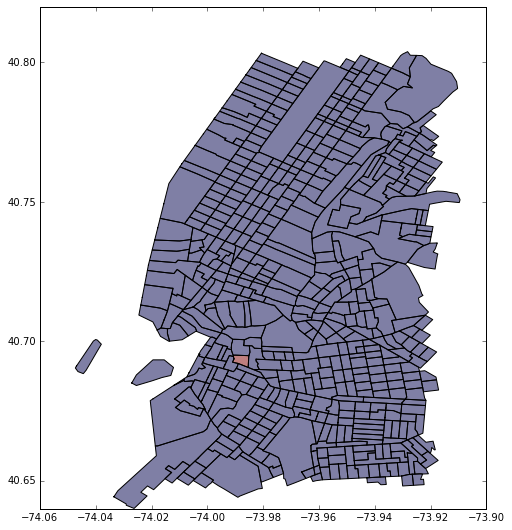

In [12]:
ct_shape_Zoom.plot(column = 'index', figsize=(9,9), cmap='seismic')

### Figure 2
Shows the census track where CUSP is located. We notice that we identified the location correctly.